# PixelFrame engineering design demo

To do

actual length for absolute value of tendon profile
servicability from the model

Import required packages

In [36]:
using Pkg
Pkg.activate("..");
Pkg.status()
Pkg.instantiate()

  Activating project at `e:\dev\ConcreteExplorer`


Status `E:\dev\ConcreteExplorer\Project.toml`
  [acfe5cae] AsapSections v0.1.0 `https://github.com/keithjlee/AsapSections#main`
  [336ed68f] CSV v0.10.12
  [13f3f980] CairoMakie v0.11.6
  [a93c6f00] DataFrames v1.6.1
  [59287772] Formatting v0.4.2
  [f6369f11] ForwardDiff v0.10.36
  [e9467ef8] GLMakie v0.9.6
  [682c06a0] JSON v0.21.4
  [ee78f7c6] Makie v0.20.5
  [01bcebdf] Nonconvex v2.1.3
  [d3d89cbb] NonconvexMMA v1.0.0
  [b43a31b8] NonconvexNLopt v0.1.8
  [429524aa] Optim v1.9.1
⌃ [7f7a1694] Optimization v3.20.2
⌃ [4e6fcdb7] OptimizationNLopt v0.1.8
  [49802e3a] ProgressBars v1.5.1
  [90137ffa] StaticArrays v1.9.2
  [3a884ed6] UnPack v1.0.2
  [e88e6eb3] Zygote v0.6.69
  [10745b16] Statistics v1.9.0
Info Packages marked with ⌃ have new versions available and may be upgradable.

In [37]:
using CSV
using DataFrames
using JSON
using Dates
using ProgressBars
using UnPack
using Makie, GLMakie


Load functions associate with deflection calculation

Check current directory

In [38]:
pwd()

"e:\\dev\\ConcreteExplorer\\src"

In [39]:
include("Functions/definition.jl");
include("Functions/functions.jl");
include("Functions/Interpolations.jl");

LoadError: LoadError: UndefVarError: `PixelFrameElement` not defined
in expression starting at e:\dev\ConcreteExplorer\src\Functions\Interpolations.jl:31

Load the precalculated catalog

In [41]:
# catalog = CSV.read("Catalogs/test_catalog.csv", DataFrame); #load the pre-calc catalog
catalog = CSV.read("Catalogs/FEB1_1_catalog_static.csv", DataFrame); #load the pre-calc catalog

sort!(catalog, [:carbon, :fc′, :as, :dps])


println("The catalog was sorted by ascending order from:\ncarbon -> fc′ -> as -> dps")
println(catalog[1:20,:])

The catalog was sorted by ascending order from:
carbon -> fc′ -> as -> dps
20×15 DataFrame
 Row │ fc′      fR1      fR3      as       dps      fpe      Pu       Mu       Vu       carbon   L        t        Lc       T        ID    
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Int64 
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │    37.0     2.85     3.37    198.0      0.0      0.0  575.38   140.272  56.2229  14.2971    205.0     35.0     30.0      2.0      2
   2 │    37.0     2.85     3.37    198.0      0.0     46.5  570.592  138.826  56.2229  14.2971    205.0     35.0     30.0      2.0      5
   3 │    37.0     2.85     3.37    198.0      0.0     93.0  565.804  137.553  56.2229  14.2971    205.0     35.0     30.0      2.0      8
   4 │    37.0     2.85     3.37    198.0      0.0    139.5  561.017  13

Load the demand file   

In [42]:
#load demands into a dictionary
demand_path = joinpath(@__DIR__, "Demands/test_input_CISBAT_dataset.json");
open(demand_path, "r") do f
    global demands = DataFrame(JSON.parse(f, dicttype=Dict{String,Any}))
    ns = size(demands)[1]
    demands[!,:idx] = 1:ns
    println("Demands were loads from:\n", demand_path)
end
println(demands[1:10,:])

Demands were loads from:
e:\dev\ConcreteExplorer\src\Demands/test_input_CISBAT_dataset.json
10×8 DataFrame
 Row │ vu        s_idx  pu            e_idx  type     ec_max     mu       idx   
     │ Float64   Int64  Float64       Int64  String   Float64    Float64  Int64 
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 129.755       0  -1.4779e-15       0  primary  0.0423597  129.755      1
   2 │ 129.755       1  -7.38948e-16      0  primary  0.117666   194.632      2
   3 │ 129.755       2  -7.38948e-16      0  primary  0.180421   259.509      3
   4 │  45.9809      3   1.4779e-15       0  primary  0.230625   283.246      4
   5 │  45.9809      4   7.38948e-16      0  primary  0.268278   306.237      5
   6 │  45.9809      5  -7.38948e-16      0  primary  0.29338    329.227      6
   7 │  45.9809      6  -7.38948e-16      0  primary  0.305931   352.218      7
   8 │  45.9809      7   0.0              0  primary  0.305931   352.218      8
   9 │  45

The demand catalog was labeled with 0 index scheme, add 1 so they are compatible with Julia 1 index scheme.

In [43]:
@show old_min_e_idx = minimum(demands[!, "e_idx"]);
@show old_min_s_idx = minimum(demands[!, "s_idx"]);

@show old_max_e_idx = maximum(demands[!, "e_idx"]);
@show old_max_s_idx = maximum(demands[!, "s_idx"]);



old_min_e_idx = minimum(demands[!, "e_idx"]) = 0
old_min_s_idx = minimum(demands[!, "s_idx"]) = 0
old_max_e_idx = maximum(demands[!, "e_idx"]) = 29
old_max_s_idx = maximum(demands[!, "s_idx"]) = 13


In [44]:
demands[!,"e_idx"] .+= 1 ;
demands[!,"s_idx"] .+= 1 ;

In [45]:
@show new_min_e_idx = minimum(demands[!, "e_idx"]);
@show new_min_s_idx = minimum(demands[!, "s_idx"]);

@show new_max_e_idx = maximum(demands[!, "e_idx"]);
@show new_max_s_idx = maximum(demands[!, "s_idx"]);


new_min_e_idx = minimum(demands[!, "e_idx"]) = 1
new_min_s_idx = minimum(demands[!, "s_idx"]) = 1
new_max_e_idx = maximum(demands[!, "e_idx"]) = 30
new_max_s_idx = maximum(demands[!, "s_idx"]) = 14


mapping = Dict(types .=> 1:1:length(types)) = Dict("primary" => 1, "secondary" => 2, "columns" => 3)


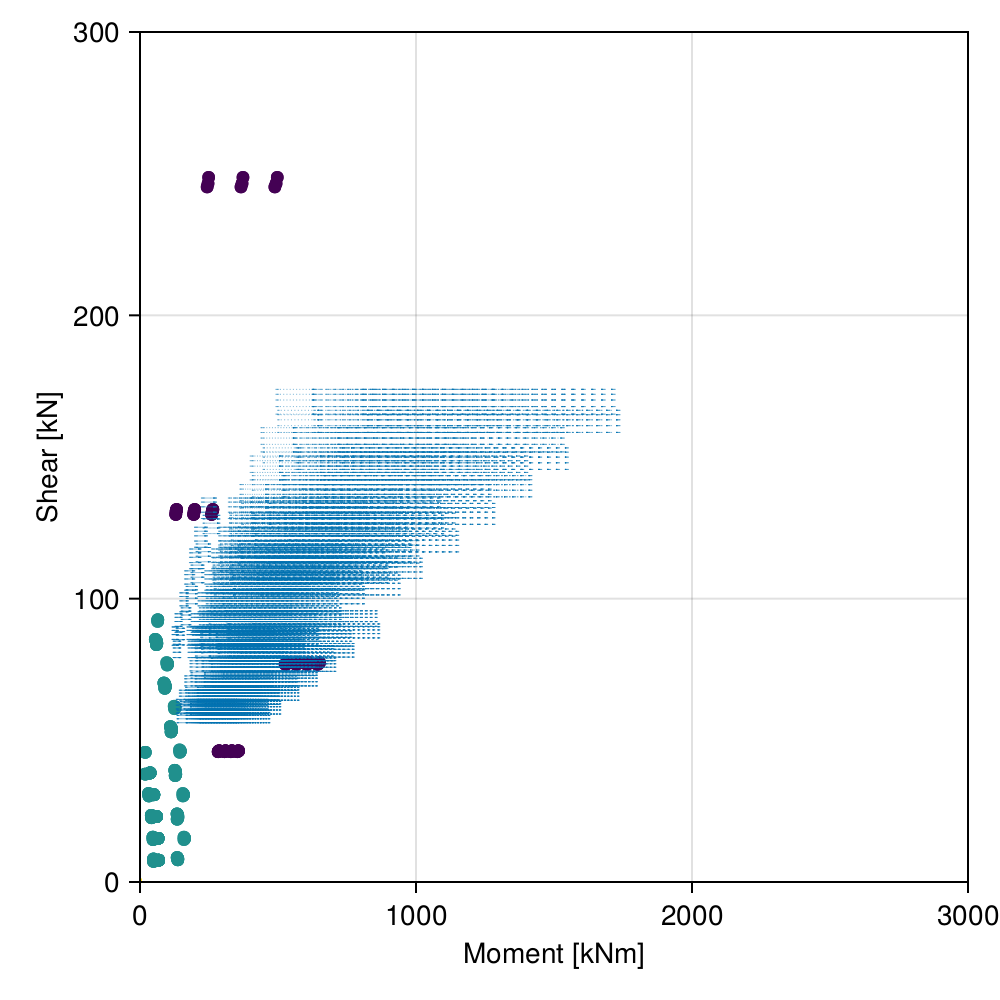

In [46]:
f1 = Figure(size = (500,500))
ax1 = Axis(f1[1,1], xlabel = "Moment [kNm]", ylabel = "Shear [kN]", limits = (0,3000,0,300)) 
types = unique(demands[!, :type])
@show mapping = Dict(types .=> 1:1:length(types))
scatter!(ax1, demands[!, :mu], demands[!,:vu], color = [mapping[t] for t in demands[!,:type]], label = demands[!, :type])
scatter!(ax1, catalog[!, :Mu], catalog[!, :Vu], marker = '.', alpha = 0.5, transparency = true, markersize = 5)
f1

Fix redundant element indices due to Primary and Secondary labels

In [47]:
global e_idx = 1 
for i in 1:size(demands)[1]
    if i !=1
        demands[i-1, :e_idx] = e_idx
        if demands[i,:s_idx] < demands[i-1,:s_idx]
            global e_idx +=1 
        end
        
    end
    if i == size(demands)[1]
        demands[i, :e_idx] = e_idx
    end
end

Create a function to filter only feasible designs in a demand point

In [69]:

"""
filter feasible demands
"""
function filter_demands(demands::DataFrame, catalog::DataFrame)

    ns = size(demands)[1]          #total number of sections
    ne = unique(demands[!, :e_idx]) #total number of elements
    nc = size(catalog, 1)           #total number of available choices

    output_results = Dict{Int64,Vector{Int64}}() #map between demands and indices of the feasible section.
    demands[!, "total_results"] = zeros(Int64, size(demands)[1])
    #go through each section and filter the feasible designs from the catalog.
    for i = 1:ns
        en = demands[i, "e_idx"]
        sn = demands[i, "s_idx"]
        # push!(elements_to_sections[en], sn)

        pu = demands[i, "pu"]
        mu = demands[i, "mu"]
        vu = demands[i,"vu"]*0.9
        ec_max = demands[i, "ec_max"]

        global feasible_sections = filter([:Pu, :Mu, :Vu, :dps] => (x1, x2, x3, x4) ->
                x1 > pu &&
                x2 > mu &&
                # x3 > vu && 
                x4 <= ec_max * 1000,
            catalog
        )

        if size(feasible_sections)[1] == 0 #if the number of feasible results = 0
            println(feasible_sections[!, :ID])
            println("section $sn: element $en")
            output_results[i] = [0]
            demands[i, "total_results"] = 0
            # println(outr)
        else
            output_results[i] = feasible_sections[!, :ID]
            demands[i, "total_results"] = length(feasible_sections[!, :ID])
            # println(outr)
        end
    end

    return output_results
end


filter_demands

In [73]:
"""
Find the optimum result for each element.
    
    !! not optimum yet.
For the same element, will use the same fc′ steel size and post tensioning stress.

"""
function find_optimum(output_results::Dict{Int64, Vector{Int64}}, demands::DataFrame)
    total_ns = size(demands)[1] #get total number of section points.
    ne = unique(demands[!, :e_idx]) 

    #Map element indices to indices of sections indices on those elements.
    elements_to_sections = Dict(k => Int[] for k in unique(demands[!, :e_idx]))
    for i = 1:total_ns
        en = demands[i, :e_idx]
        # sn = demands[i, "s_idx"]
        push!(elements_to_sections[en], i)
    end

    #element index to list of designs
    elements_designs = Dict(k => [[]] for k in unique(demands[!, :e_idx])) 
    sections_to_designs = Dict(k => Vector{Float64}() for k in demands[!, :idx])

    #find fc′, as, and fpe that appear in all sections in an element.
    # for i in ProgressBar(ne) #loop each element
    for i in ne
        println("Element $i out of $(length(ne)) elements")
        sections = elements_to_sections[i] #sections associated with this element

        ns = length(sections)     # number of sections in this element 

        #start from the middle-ish section (n/2 or (n-1)/2)
        #note that section is in the form of 1,2,3,..., ns.
        mid = div(ns, 2)
        
        #get the feasible designs for the middle section
        feasible_idx = output_results[sections[mid]]

        #catalog was already sorted, so I think we can leave this part, just filter, to save time.
        mid_catalog = sort(catalog[feasible_idx, :], [:carbon, :fc′, :dps])
        # mid_catalog = catalog[feasible_idx, :]

        #now, loop each design in the sub catalog, see if "as" and "fpe" are available in all sections.
        #if not, remove that design from the sub catalog.
        #if yes, keep it.

        #select each design, check if as and fpe exist for the the section
        global_d = 0 
        for d_idx in 1:size(catalog)[1]
            d = mid_catalog[d_idx, :]

            all_as  = true
            all_fpe = true
            serviceability_check = true

            for s in sections
                # println(s)
                #check if the design is available in that section.
                #if not, remove it from the sub catalog.
                #if yes, keep it.

                #at this version, make sure that the fR1 and fR3 are also matched.
                # if !(d[:fc′] ∈ catalog[output_results[s], :fc′])
                #     all_fc′ = false
                #     break
                # end

                if !(d[:as] ∈ catalog[output_results[s], :as])
                    all_as = false
                    break
                end
                if !(d[:fpe] ∈ catalog[output_results[s], :fpe])
                    all_fpe = false
                    break
                end
            end
        end

        if !all_fpe ||!all_as 
            println("Warning, can't find the solution for element $i")
        end
        

        #get the first one, they will appear in the entire thing anyway.
        this_fc′ = mid_catalog[global_d, :fc′]
        this_fpe = mid_catalog[global_d, :fpe]
        this_as = mid_catalog[global_d, :as]

        sections_designs = Vector{Vector}(undef, ns)
        for is in eachindex(elements_to_sections[i])
            #current section index
            s = elements_to_sections[i][is]

            feasible_idx = output_results[s]
            
            fc′_fpe_as(fc′::Float64, fpe::Float64, as::Float64) = fc′ == this_fc′ && fpe == this_fpe && as == this_as
            # fpe_as(fpe::Float64, as::Float64) = fpe == this_fpe && as == this_as

            this_catalog = filter([:fc′, :fpe, :as] => fc′_fpe_as, catalog[output_results[s], :])

            sort!(this_catalog, [:carbon, :dps])

            #get the first one, it's the lowest carbon
            select_ID = this_catalog[1, :ID]
            #find lowest e for this one.
            sections_designs[is] = collect(catalog[select_ID, :])
            # println(sections_designs[is])
        end

        #create a pixelframeelement and/or section here with the given parameters 
        L, t, Lc = [205.0 35.0 30.0]
        compoundsection =  make_Y_layup_section(L, t, Lc)
        pixelframeelement = PixelFrameElement() 
        Le = ns*500.0

        pixelframeelement.fc′ = this_fc′ # Concrete strength [MPa] ****Should update on the test day using cylinder test***
        # Ec = 4700.0*sqrt(fc′) # MPa  ACI fc-> Concrete modulus relationship [MPa]
        pixelframeelement.Ec = 58000.0 # MPa  from the cylinder test
        pixelframeelement.Eps = 70000.0 #Post tensioning steel modulus [MPa]
        pixelframeelement.fpy = 0.002 * pixelframeelement.Eps #MPa  
        #Safe load on the website https://www.engineeringtoolbox.com/wire-rope-strength-d_1518.html 
        # is ~ 150 MPa. Currently 140 MPa :)

        # PixelFrame section/element properties
        centroid_to_top = 100.0 #[mm] ~half of 205mm
        pixelframeelement.em = mid_catalog[global_d, :dps]# Eccentricity at the middle of the member [mm]
        pixelframeelement.es = 0.0 # Eccentricity at the support of the member   [mm]
        pixelframeelement.em0 = mid_catalog[global_d, :dps] # Initial eccentricity at the midspan        [mm]

        pixelframeelement.dps0 = centroid_to_top + pixelframeelement.em0 # Initial distance from the top to the point of application of the load [mm]
        pixelframeelement.Ls = Le/4 # Distance from support to the first load point [mm]
        pixelframeelement.Ld = Le/4 # Distance from support to the first deviator [mm]
        pixelframeelement.L = Le # Total length of the member [mm]
        # two 1/4" bars with 1200 lb capacity
        pixelframeelement.Aps = this_as # Total area of the post tensioned steel [mm2]
        #Pure concrete area = 18537.69 mm2
        #Transformed steel area = 347.96 mm2 
        pixelframeelement.Atr = compoundsection.area # Transformed area of the cross section [mm2] (= Concrete area if there is no embedded rebars)
        pixelframeelement.Itr = compoundsection.Ix #moment of inertia [mm4], no embedded steel, therefore, only from concrete.
        # pixelframeelement.Itr = 1.082e+8 #this number includes deviated steels.

        pixelframeelement.Zb = pixelframeelement.Itr/centroid_to_top # Elastic modulus of the concrete section from the centroid to extreme tension fiber [mm3]
        # If there are multiple materials, transformed section geometry is needed for Zb (and everything related to section area)

        #forces
        pixelframeelement.w = pixelframeelement.Atr / 10^9 * 2400.0 * 9.81 # Selfweight [N/mm]
        pixelframeelement.mg = pixelframeelement.w * pixelframeelement.L^2 / 8.0 # Moment due to selfweight [Nmm]
        pixelframeelement.fr = 0.7 * sqrt(pixelframeelement.fc′) # Concrete cracking strenght [MPa]
        pixelframeelement.r = sqrt(pixelframeelement.Itr / pixelframeelement.Atr) # Radius of gyration [mm]
        pixelframeelement.ps_force = pixelframeelment.Aps*this_fpe # Post tensioning force [N]
        pixelframeelement.Mdec = pixelframeelement.ps_force*pixelframeelement.em
        pixelframeelement.concrete_force = pixelframeelement.ps_force*cos(24.0*pi/180.0) # should use actual value 
        pixelframeelement.fpe = pixelframeelement.ps_force/pixelframeelement.Aps # Effective post tensioning stress [MPa] ***will input the one on the test day***
        pixelframeelement.ϵpe = pixelframeelement.fpe / pixelframeelement.Eps # Effective post tensioning strain [mm/mm]
        #find moment due to the applied force.
        pixelframeelement.ϵce = pixelframeelement.ps_force*pixelframeelement.em/pixelframeelement.Zb/pixelframeelement.Ec - pixelframeelement.concrete_force/pixelframeelement.Atr/pixelframeelement.Ec # effetive strain in the concrete [mm/mm]
        #for using test setup
        pixelframeelement.test = false

        #for the current stage of the model,
        #we will have 2 deviators, with interpolated 2/3 of the length of the element.
        #with this, <Need proved, but this should be more conservative???>. Less post tensioned than the actual beam.
        #Current PixelFrameSize
        
        load_m = 4*demands[mid, :mu]/Le*1000 #N
        load_v = demands[mid, :vu]*1000

        load = load_m > load_v ? load_m : load_v
        dis_history, P =  get_Deflection(pixelframeelement, load)

        δ = dis_history[end]

        elements_designs[i] = [sections_designs, δ, δ/(Le/240)]

    end

    for i in ne
        sections = elements_to_sections[i]
        for design in eachindex(elements_designs[i])
            sections_to_designs[sections[design]] = elements_designs[i][design]
        end
    end

    return elements_designs, elements_to_sections, sections_to_designs
end

find_optimum

Filter the catalog entries that meet the demands.

In [74]:
output_results= filter_demands(demands,catalog)


Dict{Int64, Vector{Int64}} with 552 entries:
  56  => [2, 5, 8, 11, 14, 17, 20, 23, 26, 29  …  162141, 162144, 162147, 16215…
  35  => [1361, 1364, 1367, 1370, 1373, 1376, 1379, 6059, 6062, 6065  …  164403…
  425 => [2, 5, 8, 11, 14, 17, 20, 23, 26, 29  …  163533, 163536, 163539, 16354…
  429 => [2, 5, 8, 11, 14, 17, 20, 23, 26, 29  …  163533, 163536, 163539, 16354…
  60  => [72092, 72095, 76790, 76793, 81488, 81491, 86186, 86189, 90884, 90887 …
  220 => [47, 50, 53, 56, 59, 62, 65, 68, 71, 74  …  163533, 163536, 163539, 16…
  308 => [2, 5, 8, 23, 26, 29, 32, 35, 38, 41  …  163533, 163536, 163539, 16354…
  67  => [72092, 72095, 76790, 76793, 81488, 81491, 86186, 86189, 90884, 90887 …
  215 => [2, 5, 8, 11, 14, 17, 20, 23, 26, 29  …  163533, 163536, 163539, 16354…
  73  => [494, 5192, 9890, 14588, 19286, 575, 578, 581, 584, 587  …  163359, 16…
  319 => [2, 5, 8, 23, 26, 29, 32, 35, 38, 41  …  163533, 163536, 163539, 16354…
  251 => [44, 47, 50, 53, 56, 59, 62, 65, 68, 71  …  163533, 163

Check number of available designs per section.

In [75]:
# elements_designs, elements_to_sections  = find_optimum(output_results, demands)
elements_designs, elements_to_sections, sections_to_designs  = find_optimum(output_results, demands)



Element 1 out of 57 elements


In [52]:
sections_to_designs
open("Results/0102_section_to_designs.json","w") do f
    JSON.print(f, sections_to_designs)
end

UndefVarError: UndefVarError: `sections_to_designs` not defined

In [53]:
@show sections_to_designs

UndefVarError: UndefVarError: `sections_to_designs` not defined

Save the design result

In [54]:
open("Results/designs_results_22_01.json","w") do f
    JSON.print(f, elements_designs)
end

UndefVarError: UndefVarError: `elements_designs` not defined

## 3. Visualizing the results

Load required packages

In [55]:
using Makie, GLMakie, CairoMakie
using JSON
using DataFrames, CSV

Load back the design results

In [56]:
designs = JSON.parsefile(joinpath(@__DIR__,"Results/designs_results_22_01.json"), dicttype = Dict{String,Vector{Vector{Float64}}});

ne = length(designs)
println("There are $ne elements.")


ErrorException: Unexpected end of input
Line: 0
Around: ......
           ^


In [57]:
designs["1"]

UndefVarError: UndefVarError: `designs` not defined

In [58]:
designs["5"]

UndefVarError: UndefVarError: `designs` not defined

In [59]:
function plot_element(element_number::Int64, designs::Dict;L::Float64 = 250.0)


sections = elements_to_sections[element_number]
element_number = string(element_number)

L = 400
tendon_profile = L.*[i[3] for i in designs[element_number]]
axial_capacity  = [i[5] for i in designs[element_number]]
moment_capacity = [i[6] for i in designs[element_number]]
shear_capacity = [i[7] for i in designs[element_number]]


axial_demand  = [ demands[i,"pu"] for i in sections]
moment_demand = [ demands[i,"mu"] for i in sections]
shear_demand  = [ demands[i,"vu"] for i in sections]


#plot center around x = 0 
@show n = length(tendon_profile)
xmax = div(n,2)*500
@show res = mod(n+1,2)*250
@show x_range = -xmax+res:500:xmax-res



f1 = Figure(size = (1200,600))
g = f1[1,1] = GridLayout()

axs_design = Axis(g[1,1],title = "Element $element_number", titlesize = 20,
aspect = DataAspect(),
limits = (-xmax-100, xmax+100, -1.3*L, 0.6*L),
yticks = L:-100:-L,
# yminorticks = IntervalsBetween(2),
# yminorgridvisible = true,
ylabel = "y"
)

poly!(Rect( -xmax+res, -L, (n-1)*500, L*1.5), color = (:grey,0.2))
tendon = lines!(axs_design, x_range, -tendon_profile)

axs_axial  = Axis(g[2,1],aspect = 10,
limits = (-xmax, xmax, nothing, nothing),ylabel = "Axial [kN]", 
)

axs_moment = Axis(g[3,1],aspect = 10,
limits = (-xmax, xmax, nothing, nothing),ylabel = "Moment [kNm]",
)
axs_shear  = Axis(g[4,1],aspect = 10,
limits = (-xmax, xmax, nothing, nothing),ylabel = "Shear [kN]", 
)
hidexdecorations!(axs_design, grid = false)
hidexdecorations!(axs_axial, grid = false)
hidexdecorations!(axs_moment, grid = false)

lines!(axs_axial ,x_range, axial_capacity , color = :red)
lines!(axs_moment,x_range, moment_capacity, color = :blue)
lines!(axs_shear ,x_range, shear_capacity , color = :green)

lines!(axs_axial ,x_range, axial_demand ,linestyle = :dash, color = :red)
lines!(axs_moment,x_range, moment_demand,linestyle = :dash, color = :blue)
lines!(axs_shear ,x_range, shear_demand ,linestyle = :dash, color = :green)


# for (i, label) in enumerate(["Axial [kN]", "Moment [kNm]", "Shear [kN]"])
#     Box(g[i, 2], color = :gray90)
#     Label(g[i,2], label, rotation = pi/2, tellheight = false)
# end

rowgap!(g, 10)

@show yspace = maximum(tight_yticklabel_spacing!, [axs_axial, axs_shear, axs_moment])+10

axs_axial.yticklabelspace = yspace
axs_moment.yticklabelspace = yspace
axs_shear.yticklabelspace = yspace

f1

return f1
end


plot_element (generic function with 1 method)

In [60]:
designs["11"]

UndefVarError: UndefVarError: `designs` not defined

In [61]:
plot_element(11, designs)

UndefVarError: UndefVarError: `designs` not defined

In [62]:
for i in 1:new_max_e_idx
    f = plot_element(i, designs)
    save("Results3/$i.png",f)
end

UndefVarError: UndefVarError: `designs` not defined